Import some libraries

In [81]:
import numpy as np
import time
import cv2
import os
import glob
import matplotlib.pyplot as plt

Load yolo weights and config (cfg)

In [82]:
weights_path=os.path.abspath("yolov3.weights")
config_path=os.path.abspath("yolov3.cfg")

Load the neural network in cv2

In [83]:
net=cv2.dnn.readNetFromDarknet(config_path,weights_path)

#Adjust backend settings to improve the performance
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
#net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


Get Layers Names

In [84]:
names=net.getLayerNames() #the names of layers ofyolov3 

Get the names of the 3 sampling layers 

In [85]:
layers_names=[]
for i in net.getUnconnectedOutLayers():
    layers_names.append(names[i-1])
#return layers_names    

Funtion to append the boxes , confidences and scores

In [86]:
def get_attributes(layers_output, boxes, confidences, classIDs, img_2):
    (H, W) = img_2.shape[:2]
    
    for output in layers_output:
        for detection in output:
            
            scores=detection[5:] #get the 80 classifiers
            classID=np.argmax(scores) #the class of the obj is the max of them
            confidence=scores[classID] #give each
            
            if confidence > 0.4:
                box=detection[:4] * np.array([W,H,W,H]) #multiply the box dimensions by real image dimensions
                bx,by,bw,bh=box.astype("int") #convert them to int
            
                #get the centers of opencv which are top left
                x=int(bx - (bw/2)) 
                y=int(by - (bh/2))
                boxes.append([x,y,int(bw),int(bh)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                
    return boxes,confidences,classIDs                                    

Read the labels file

In [87]:
def get_coco_names():
    labels_path=os.path.abspath("coco.names")
    labels=open(labels_path).read().strip().split("\n")
    return labels

Make non maximum submission and plot the bounding boxes in the image

In [88]:
def process_Output(boxes, confidences, classIDs, img, labels):
   
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.4, 0.2) #indexes of the selected rect to draw

    if(len(idxs) > 0): #to prevent empty object images
        for i in idxs.flatten():
             
            (x,y)=[boxes[i][0],boxes[i][1]] 
            (w,h)=[boxes[i][2],boxes[i][3]]
       
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
            cv2.putText(img, "{}: {}".format(labels[classIDs[i]], confidences[i]), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 139, 139), 2)
    return img

    
    
    

Pipelining

In [89]:
def process_image(img_1):
    blob = cv2.dnn.blobFromImage(img_1, 1/255.0, (416, 416), crop=False, swapRB=False) #make all pic on the network with size(416,416)
    net.setInput(blob)

    layers_output = net.forward(layers_names) #the dimensions of the 3 layers (507,85) (2028,85) (8112,85)
    
    #initializing the boxes,confidences,classIDs
    boxes = []
    confidences = []
    classIDs = []
    
    boxes,confidences,classIDs=get_attributes(layers_output,boxes,confidences,classIDs,img_1) #get boxes,confidences,classIDs
    labels=get_coco_names() #get labels from coc dataset
    img=process_Output(boxes, confidences, classIDs, img_1, labels) #make non max sup and draw output 
    
    return img

Image Processing

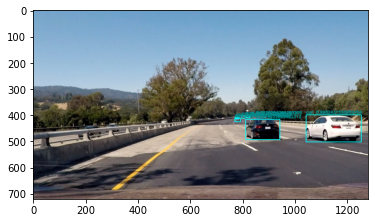

In [90]:
#image_path=os.path.abspath("test4.jpg")
#img_1=cv2.imread(image_path)
#img=cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
#img=process_image(img)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)
#cv2.imshow("IMAGE",img)
#cv2.waitKey(0)


Video processing

In [91]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip("project_video1.mp4")
out_clip = clip.fl_image(process_image)
out_clip.write_videofile("output_trial.mp4", audio=False)

